#Lecture 8. Multigrid

## Motivation
Elliptic problems are typically **ill-conditioned**.
For instance, complexity to solve $N\times N$ linear system from the Poisson equation:
* Sparse LU <font color='red'>$\mathcal{O}(N^{3/2})$ </font>
* Direct FFT solver  <font color='red'>$\mathcal{O}(N \log N)$</font> (works only in rectangular domains)
* Iterative methods <font color='red'>$\mathcal{O}(Nk)$</font>, k is number of iterations
 * $k=\mathcal{O}(N^2)$ - Jacobi or Gauss-Seidel
 * $k = \mathcal{O}(N)$ - Kyrlov subspace methods (cg, gmres)
* **Multigrid method** <font color='red'>$\mathcal{O}(N)$</font>. Optimal complexity

The trick is that multigrid uses additional information about the grid structure

## Idea
Iterative methods <font color='red'> smooth error </font> (works for **any method**, inculinding Jacobi, Gauss-Seidel or ILU).

As a result, error can be approximated on a coarser grid and so on **recursively**.

## A bit of history
* Was initially proposed by Fedorenko (1961) (многосеточный метод)
* Became popular after works of Brandt (1973, 1977)

## Convergence issues and  smoothing property of iterative methods

In the currect section we will show that iterative methods does not have optimal complexity, but have some nice property (smoothing) that will help us to build an $\mathcal{O}(N)$ method (multigrid).

#####  Model problem 

Consider a discretized 1D diffusion equation with zero boundary conditions

$$A_h u_h = f_h,$$ 

where
$$
A_h = \frac{1}{h^2} 
\begin{pmatrix}
2 & -1 \\
-1 & 2 & -1 \\
& -1 & \ddots & \ddots \\
& & \ddots & \ddots & -1 \\
& & & -1 & 2
\end{pmatrix}\quad \text{of size $N\times N$, $\ $ $ h = N^{-1}$}
$$
As we know so far $$\lambda_k(A_h) = \frac{4}{h^2} \sin^2 \frac{\pi kh}{2}>0, \quad \text{cond}(A_h) = \frac{\lambda_\max}{\lambda_\min} = \mathcal{O}\left(\frac{1}{h^2}\right)$$

##### Iterative process
Consider Jacobi iterative process with relaxation parameter $\tau$ (fixed-point iteration with diagonal as a perconditioner):

$$
u^{(k+1)} = u^{(k)} - \tau \ D^{-1}(A_h u^{(k)} - f_h), \quad D = \text{diag}(A_h)\equiv \frac{2}{h^2} I. 
$$

##### Convergence. Bad news
Let us show that the number of iterations required to get accuracy $\epsilon$ is $\mathcal{O}(N^2 \ln \epsilon)$.

For the error $e^{(k)} = u^{(k)} - u_h$ we have
$$
e^{(k+1)} = \left(I - \frac{\tau h^2}{2}A_h \right) e^{(k)}.
$$

It is known that (**show why**) the optimal tau is $\frac{\tau_{\text{opt}}h^2}{2} = \frac{2}{\lambda_{\min} + \lambda_{\max}}$.

Therefore,
$ \|e^{(k)}\|_2 \leqslant \left(\frac{1 - \lambda_\min/\lambda_\max}{1 + \lambda_\min/\lambda_\max}\right)^{k}\|e^{(0)}\|_2 = \left(\frac{1 - \mathcal{O}(N^{-2})}{1 + \mathcal{O}(N^{-2})}\right)^{k}\|e^{(0)}\|_2\leqslant \epsilon \quad \Longrightarrow$ <font color='red'>$\quad k = \mathcal{O}(N^2 \ln \epsilon)$</font>.

For conjugate gradients $ \|e^{(k)}\|_2 \leqslant \left(\frac{1 - \sqrt{\lambda_\min/\lambda_\max}}{1 + \sqrt{\lambda_\min/\lambda_\max}}\right)^{k}\|e^{(0)}\|_2 \quad \Longrightarrow$ <font color='red'>$\quad k = \mathcal{O}(N \ln \epsilon)$</font>.

The overall algorithm consists of $k$ matvecs $\quad \Longrightarrow \quad$ the total complexity is $\mathcal{O}(N k)$.

**Convergence example**

The following example shows that even for $N = 20$ Jacobi method requires $1000$ iterations to reach $\epsilon=10^{-4}$

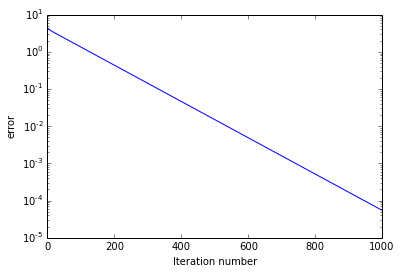

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix

n = 20
ex = np.ones(n);
lp1 = n**2*sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

niters = 1000
x = np.zeros(n)
res_all = []
for i in xrange(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
    
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_all)
plt.xlabel('Iteration number')
plt.ylabel('error')

##### Smoothing property. Good news 
Iterative processes remove high-frequency components in the error! Let us show that.

From the previous slide
$$
e^{(k+1)} = T e^{(k)} = T^{k} e^{(0)}, \quad \text{where}\quad T = \left(I - \frac{\tau h^2}{2}A_h \right).
$$

Let $$T \psi_i = \mu_i \psi_i,$$ 
where $\psi_i$ and $\mu_i$, $i=1,\dots,N$ are eigenvectors and eigenvalues of $T$.
Since $\{\psi_i\}$ is orthonormal basis (**explain why**), we have
$$e^{(0)} = \sum_{i=1}^N c_i \psi_i,$$
with some coefficients $c_i$. Therefore,
$$
e^{(k+1)} = T^{k} e^{(0)} = \sum_{i} c_i\lambda_i^k \psi_i
$$

Now the goal is to show that $\lambda_i^k$ decays fast enough with respect to $k$ when, for instance, $i>N/2$ (high-frequecy part of the spectrum). Indeed, 
$$
| \lambda_i(T)| = |1 - \frac{h^2}{4}\lambda_k(A_h)|<({\bf\text{show why}})<\frac{1}{2},\quad \text{when}\quad k>N/2 
$$
So, the high-frequency part of the error ($k>N/2$) becomes at least <font color='red'> 2 times smaller on each iteration </font>.

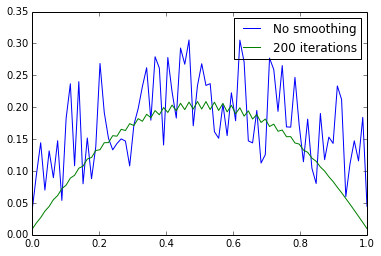

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix

n = 80
ex = np.ones(n);
lp1 = n**2 * sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=4, which='LR')
ev2, vec = spla.eigs(lp1, k=4, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = np.real(2.0/(lam_max + lam_min))

sol = spla.spsolve(lp1, rhs)
niters = 1000
x = 0.2*np.random.random(n) #random x0 to add high frequencies to the error
err_all = []
grid = np.linspace(0, 1, n)
for i in xrange(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    err = spla.spsolve(lp1, rr)
    err_all.append(err)
init, = plt.plot(grid, err_all[0])
smooth, = plt.plot(grid, err_all[200])
plt.legend([init, smooth], ['No smoothing', '200 iterations'])

#x = np.linspace(0, 1, n)
#def set_cursor(i):
#    plt.ylim(0, 1.1*np.max(err_all[0]))
#    plt.plot(x, err_all[i])
#    plt.xlabel('space')
#    plt.ylabel('error[i]')
#    plt.title('Error smoothing')
#from IPython.html.widgets import interact
#interact(set_cursor, i=(0, niters-1, 5))

## Geometric Multigrid

Now we know that in an iterative processes 
* High-frequecies (k>N/2) in error decay twice at each iteration 
* Low-frequencies in error decay really slow

But, we can approximate **smooth error vector on coarser grids**!

Equation on error: $A_h e_{h} = r_h $, where $r_h = f_h - A_h u$ is residual. Given $e_h$ we can simply get $u_h = e_h + u$

##### A Two-Grid Cycle (almost multigrid :)) 

1. **Smoothing.** Do several iterations (say 2-3 Jacobi iterations) to reach $u$ with smooth $e_h = u - u_h$
2. **Restriction.** Restrict the residual $r_h$ to the coarser grid $r_{2h} = Rr_h$
3. Solve $A_{2h} e_{2h} = r_{2h}$
4. **Prolongarion** (Interpolation). $e_h \approx P e_{2h}$
5. $u:= e_{h} + u$, then repeat from 1 if necesarry

Here 
* $R$ - restriction matrix
* $P$ - prolongation matrix

For the 1D case, N = 7:
$$
   P = 
 \frac{1}{2}
\begin{pmatrix}
1& \\
2& \\
1& 1& \\
 & 2& \\ 
 & 1& 1 \\
 &  & 2 \\ 
 &  & 1
\end{pmatrix},
\quad
R = \frac{1}{2} P^{T}
$$

In the 2D case:
$$
 P_{2D} = P\otimes P, \quad R_{2D} = R\otimes R\equiv \frac{1}{4}P_{2D}^{T}, 
$$
which corresponds to the following stencils

$$
\text{Restriction:}\quad
\begin{bmatrix}
  \frac{1}{16} & \frac{1}{8} & \frac{1}{16} \\
  \frac{1}{8} & \frac{1}{4} & \frac{1}{8} \\
  \frac{1}{16} & \frac{1}{8} & \frac{1}{16} 
\end{bmatrix}.
\quad
\text{Prolongation:} \quad
\begin{bmatrix}
  \frac{1}{4} & \frac{1}{2} & \frac{1}{4} \\
  \frac{1}{2} & 1 & \frac{1}{2} \\
  \frac{1}{4} & \frac{1}{2} & \frac{1}{4} 
\end{bmatrix}.
$$

$A_{2h}$ can be chosen either as an operator on a coarser grid (from differetial formulation) or as Galerkin projection $R A_h P$.

#####  Finally... Multigrid

Multigrid need not stop at two grids! 

To find error on $2h$ we can go to $4h$ and so on. However, there are several different ways to go through grid levels.

<img width="700" src="fig/mg-cycle.jpg" />
[<a href="http://cvsp.cs.ntua.gr/research/gac/">source</a>]

1. **V-cycle**. Straightforward generalization of the two-grid cycle
2. **W-cycle**. On each coarse grid level V-cycle is called twice
3. **F-cycle** (full multigrid, FMG). Starts from the coarsest grid. Then prolongates to the next level to get a good initial approximation to run V-cycle

<!---
4. **S-cycle** (sawtooth cycle). No smoothing during restriction. Then starts from the coarsest grid and does prolongation procedures as it was in the V-cycle
-->

**W-cycle** is typically superior to a **V-cycle**. At the same time the **F-cycle** is asymptotically better than $V$ or $W$.

##### Pseudocode (V- and W-cycles)

```
def MGM(l, u_old, rhs):

    if l==0:    
0.      u_new = solve(A0, rhs)     
        
    else (l>0):    
1.      u = u_old
        u=several iterations of smoother
        
2.      res = R (A_k * u - rhs)  (residual on a coarser grid)

3.      e = 0 (initial guess for error)
        for i = 1..gamma   #gamma=1 is V-cycle, gamma=2 is W-cycle
            e = MGM(l-1, e, res)
            
4.      u_new = u + P e

    return u_new
```

##### Complexity of one cycle

Let $d$ be dimension of a problem. Then comutational cost of one cycle is
* V-cycle: $\mathcal{O} \left(N (1+2^{-d}+2^{-2d} + 2^{-3d} + \dots  )\right) = \mathcal{O} \left(\frac{N}{1 - 2^{-d}}\right)$
* F-cycle: $\mathcal{O} \left(\frac{N}{1 - 2^{-d}} (1+2^{-d}+2^{-2d} + 2^{-3d} + \dots  )\right) = \mathcal{O} \left(\frac{N}{(1 - 2^{-d})^2}\right)$

## Algebraic Multigrid

What we have considered before is called **geometric multigrid** (GMG). 

There is an alternative **algebraic multigrid** (AMG), where only sparse matrix is given (with no information concerning a grid structure). Then the grids and operators have to be constructed **automatically**.

##### Why AMG?

1. Difficult to build hierarchy of grid levels on **unstructured grids** (e.g. on irregular triangulation)
2. Uniform coarsering with linear interpolation do not take into account operator structure. As a result, smoothers sometimes can not produce good approximation to be restricted on coarse grids. That is why geometric version may fail on
 * Poisson equation with **discontinuous coefficients**
 * **Skewed operators**
3. Some problems are purely discrete with **no geometric background**
4. AMG is **black-box**, so one does not need to know how to programm multigrid (AMG is more expensive than GMG though)

##### AMG Idea
#### Smooth vectors
Vector $u$ is smooth if $\|A u\| \approx \|u\|$. This is due to the fact that $A$ amplifies high-frequencies.

####How to find neighboring points? 
Nodes $i$ and $j$ are said to be **strongly connected** if $A_{ij}$ is big enough (e.g. greater than $\alpha A_{ii}$ say with $\alpha = 0.1$ ).

#### Coarse grid
1. Remove all weak connections
2. The fact that $i$ and $j$ are strongly connected means that $u_j$ strongly influences $u_i$. So, we do not need to have both $i$ and $j$ nodes in the coarse set.

##### PyAMG

To install just run
```
conda install pyamg
```

In [15]:
import numpy as np  
import pyamg

n = 200
A = pyamg.gallery.poisson((n, n), format='csr')   
b = np.array(np.arange(A.shape[0]), dtype=float)
x = pyamg.solve(A, b, verb=True, tol=1e-8)

  Detected a Hermitian matrix
    maxiter = 400
    iteration 1
    iteration 2
    iteration 3
    iteration 4
    iteration 5
    iteration 6
    iteration 7
    iteration 8
    iteration 9
  Residual reduction ||r_k||/||r_0|| = 5.26e-08


## Summary

1. Multigrid is a strong tool to solve elliptic problems (but not limited to them!) with **optimal $\mathcal{O}(N)$ complexity**
2. Key idea: 
  * **smooth error** with iterative method
  * smoothed error can be well approximated on **coarser grids**
3. Sometimes it is not possible to use geometric interpretaion of grid hierarchy. In these cases one can use the **algebraic version**

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/alex.css", "r").read()
    return HTML(styles)
css_styling()